In [24]:
import sys
sys.path.insert(0, '/home/ldavis/timescales')
sys.path.insert(0, '/home/ldavis/experiments')

import os
import json
import pathlib
import warnings
import figures
import numpy as np
import pandas as pd
import xarray as xr
import proplot as pplt
from climopy import ureg, vreg, const

# Load data

Load the CMIP5 climatological summaries. Could concatenate these into an `Experiment` but would have to cull pressure levels.

In [ ]:
def load_ecs():  # load ECS data for each
    

In [23]:
def load_cmip(name='ta', forcing='piControl', path='/home/ldavis/data/cmip5'):  # load one variable at a time
    path = pathlib.Path(path)
    files = [file for file in path.glob('*.nc') if file.name.startswith('_'.join((name, forcing)))]
    datasets = {}
    for file in files:
        # Load data
        ds = xr.open_dataset(file).squeeze(drop=True)
        model = file.with_suffix('').name.split('-', maxsplit=1)[1].split('-', maxsplit=1)[0]  # ignore time indicator
        if not any(str(t) == 'NaT' for t in ds.time.values):  # no time reading error
            ds = ds.groupby('time.season').mean('time', keep_attrs=True)
        else:
            warnings.warn(f'Ignoring model {model!r}. Invalid time data.')
            continue
        ds.coords['model'] = model
        # Standardize vertical coordinates
        ds = ds.rename(plev='lev')
        if ds.lev.climo.units == ureg.Pa:
            ds = ds.climo.replace_coords(lev=ds.lev / 100)
            ds['lev'].attrs['units'] = 'hPa'
        if 'plev_bnds' in ds:
            ds = ds.rename(plev_bnds='lev_bnds')
            ds['lev'].attrs['bounds'] = 'lev_bnds'
        datasets[model] = ds
    print(f'Variable {name!r} forcing {forcing!r}: ' + ', '.join(datasets))
    print(f'Number of datasets: {len(datasets)}.')
    return datasets

In [4]:
cmip = load_cmip()
ds = tuple(cmip.values())[0]

/home/ldavis/miniconda3/lib/python3.8/site-packages/xarray/coding/times.py:517: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ldavis/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ldavis/miniconda3/lib/python3.8/site-packages/xarray/coding/times.py:517: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ldavis/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.p

Variable 'ta' forcing 'piControl': ACCESS1, bcc, BNU, CSIRO, EC, FGOALS, HadGEM2, inmcm4, IPSL, MIROC5, MIROC
Number of datasets: 11.


<ipython-input-3-edd0fc97b4d9>:12: UserWarning: Ignoring model 'MIROC'. Invalid time data.
  warnings.warn(f'Ignoring model {model!r}. Invalid time data.')
<ipython-input-3-edd0fc97b4d9>:12: UserWarning: Ignoring model 'MPI'. Invalid time data.
  warnings.warn(f'Ignoring model {model!r}. Invalid time data.')


# Climate summaries

Plot summaries of the climate data.

/home/ldavis/timescales/figures.py:2126: UserWarning: Not restricting limits to in-bounds data.
  else:
/home/ldavis/timescales/figures.py:2126: UserWarning: Not restricting limits to in-bounds data.
  else:
/home/ldavis/timescales/figures.py:2126: UserWarning: Not restricting limits to in-bounds data.
  else:
/home/ldavis/timescales/figures.py:2126: UserWarning: Not restricting limits to in-bounds data.
  else:


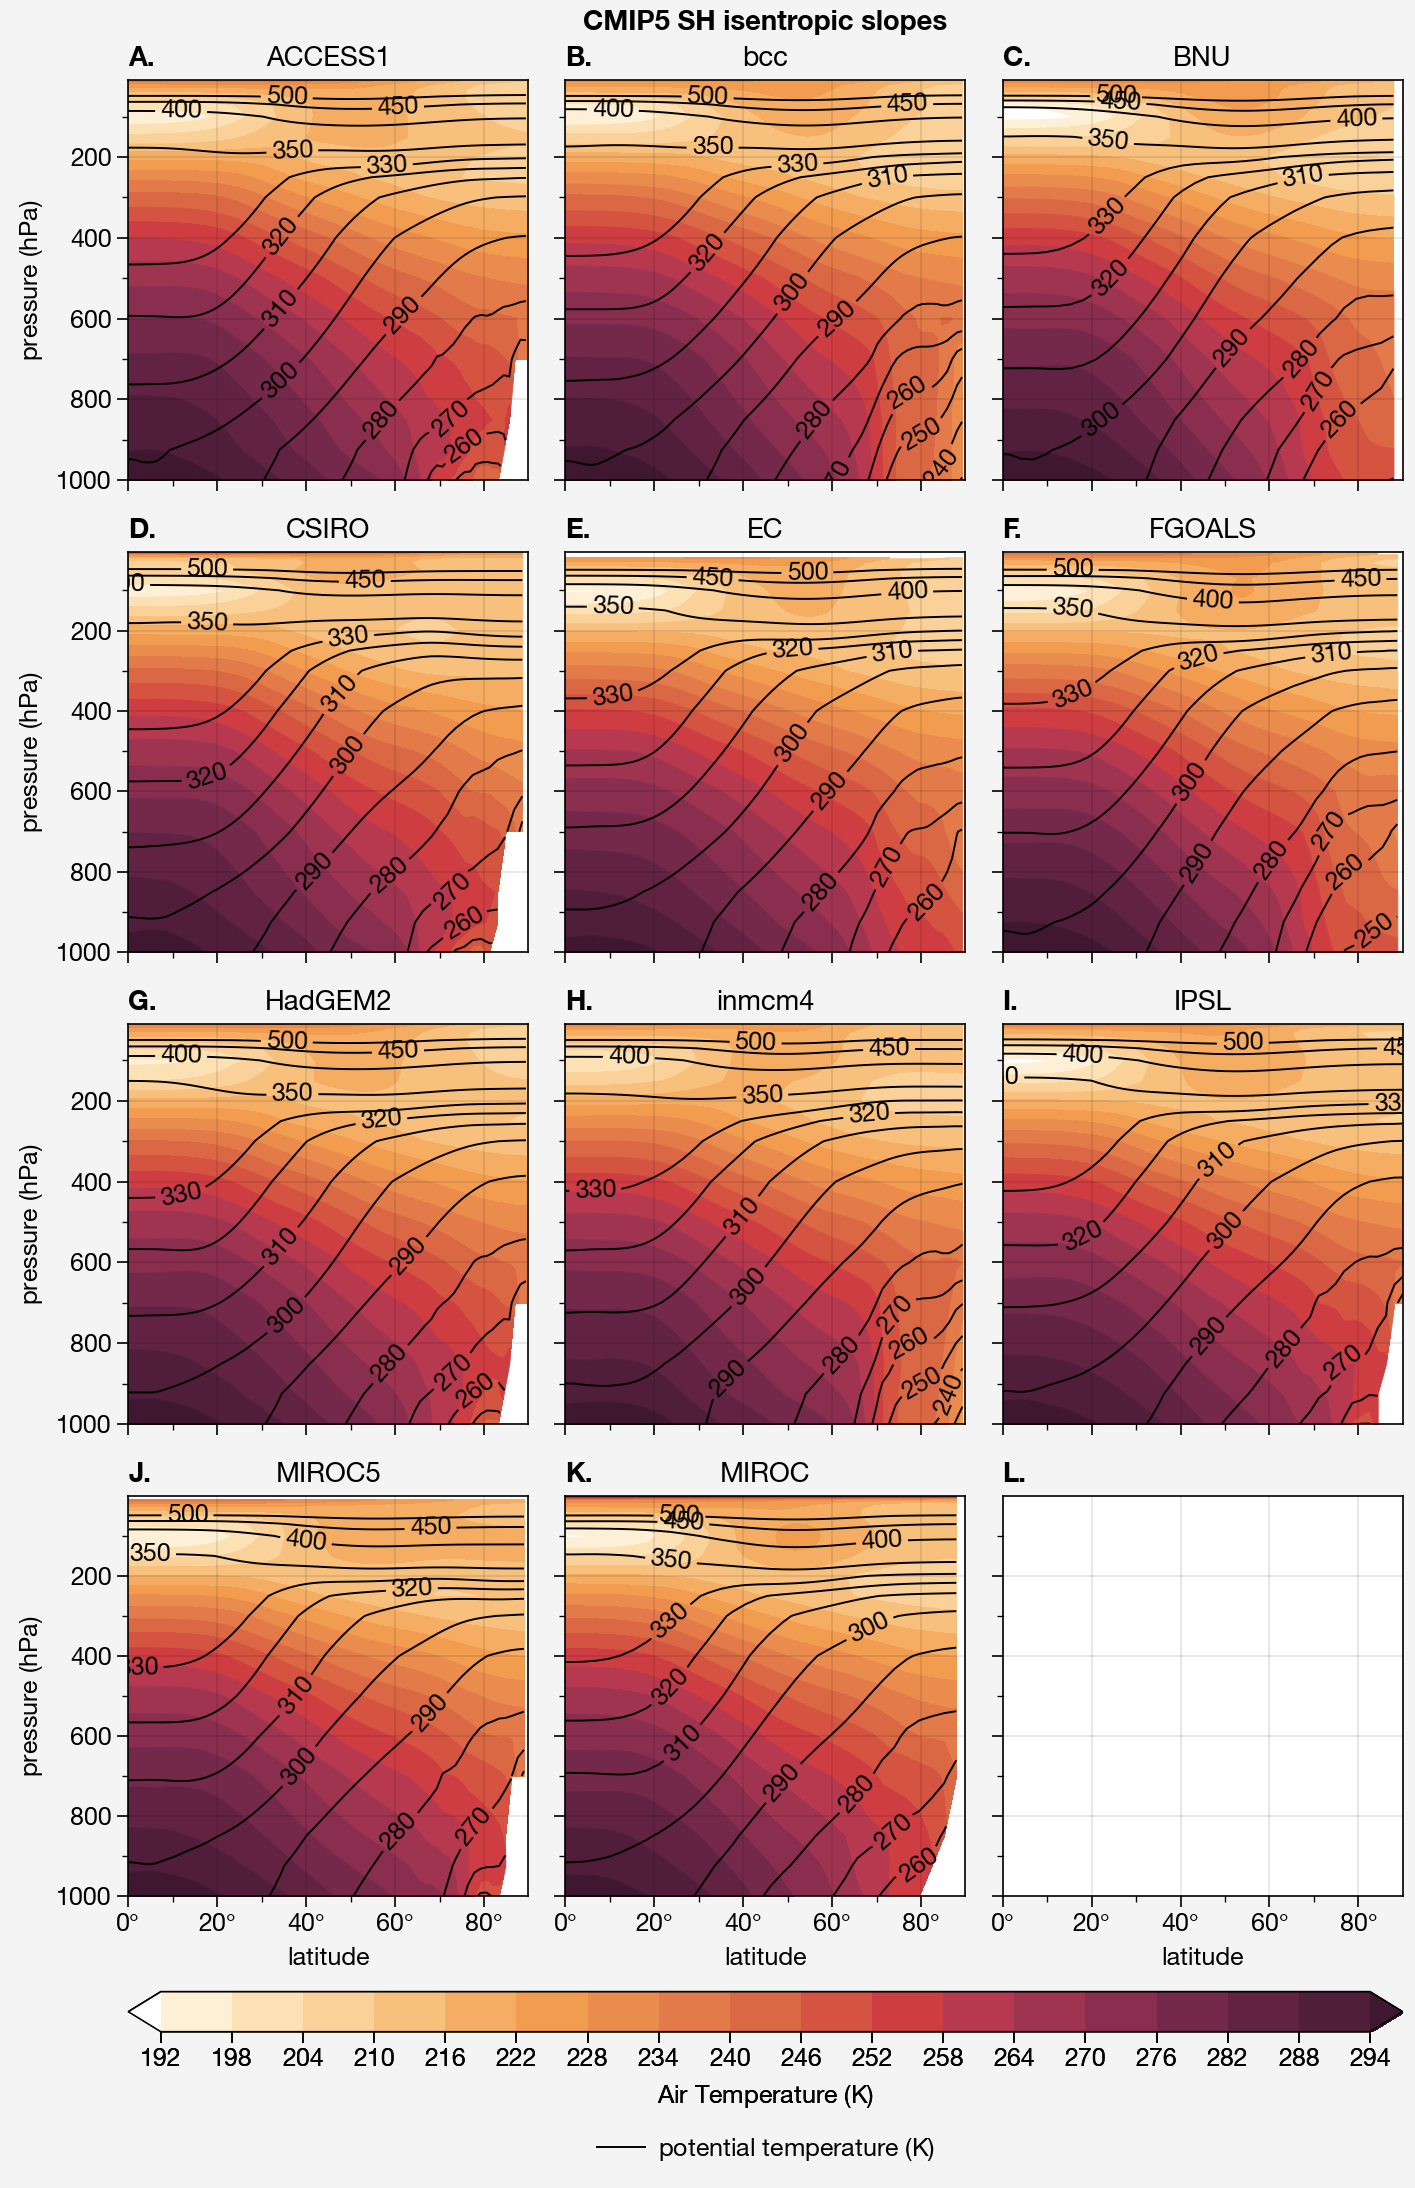

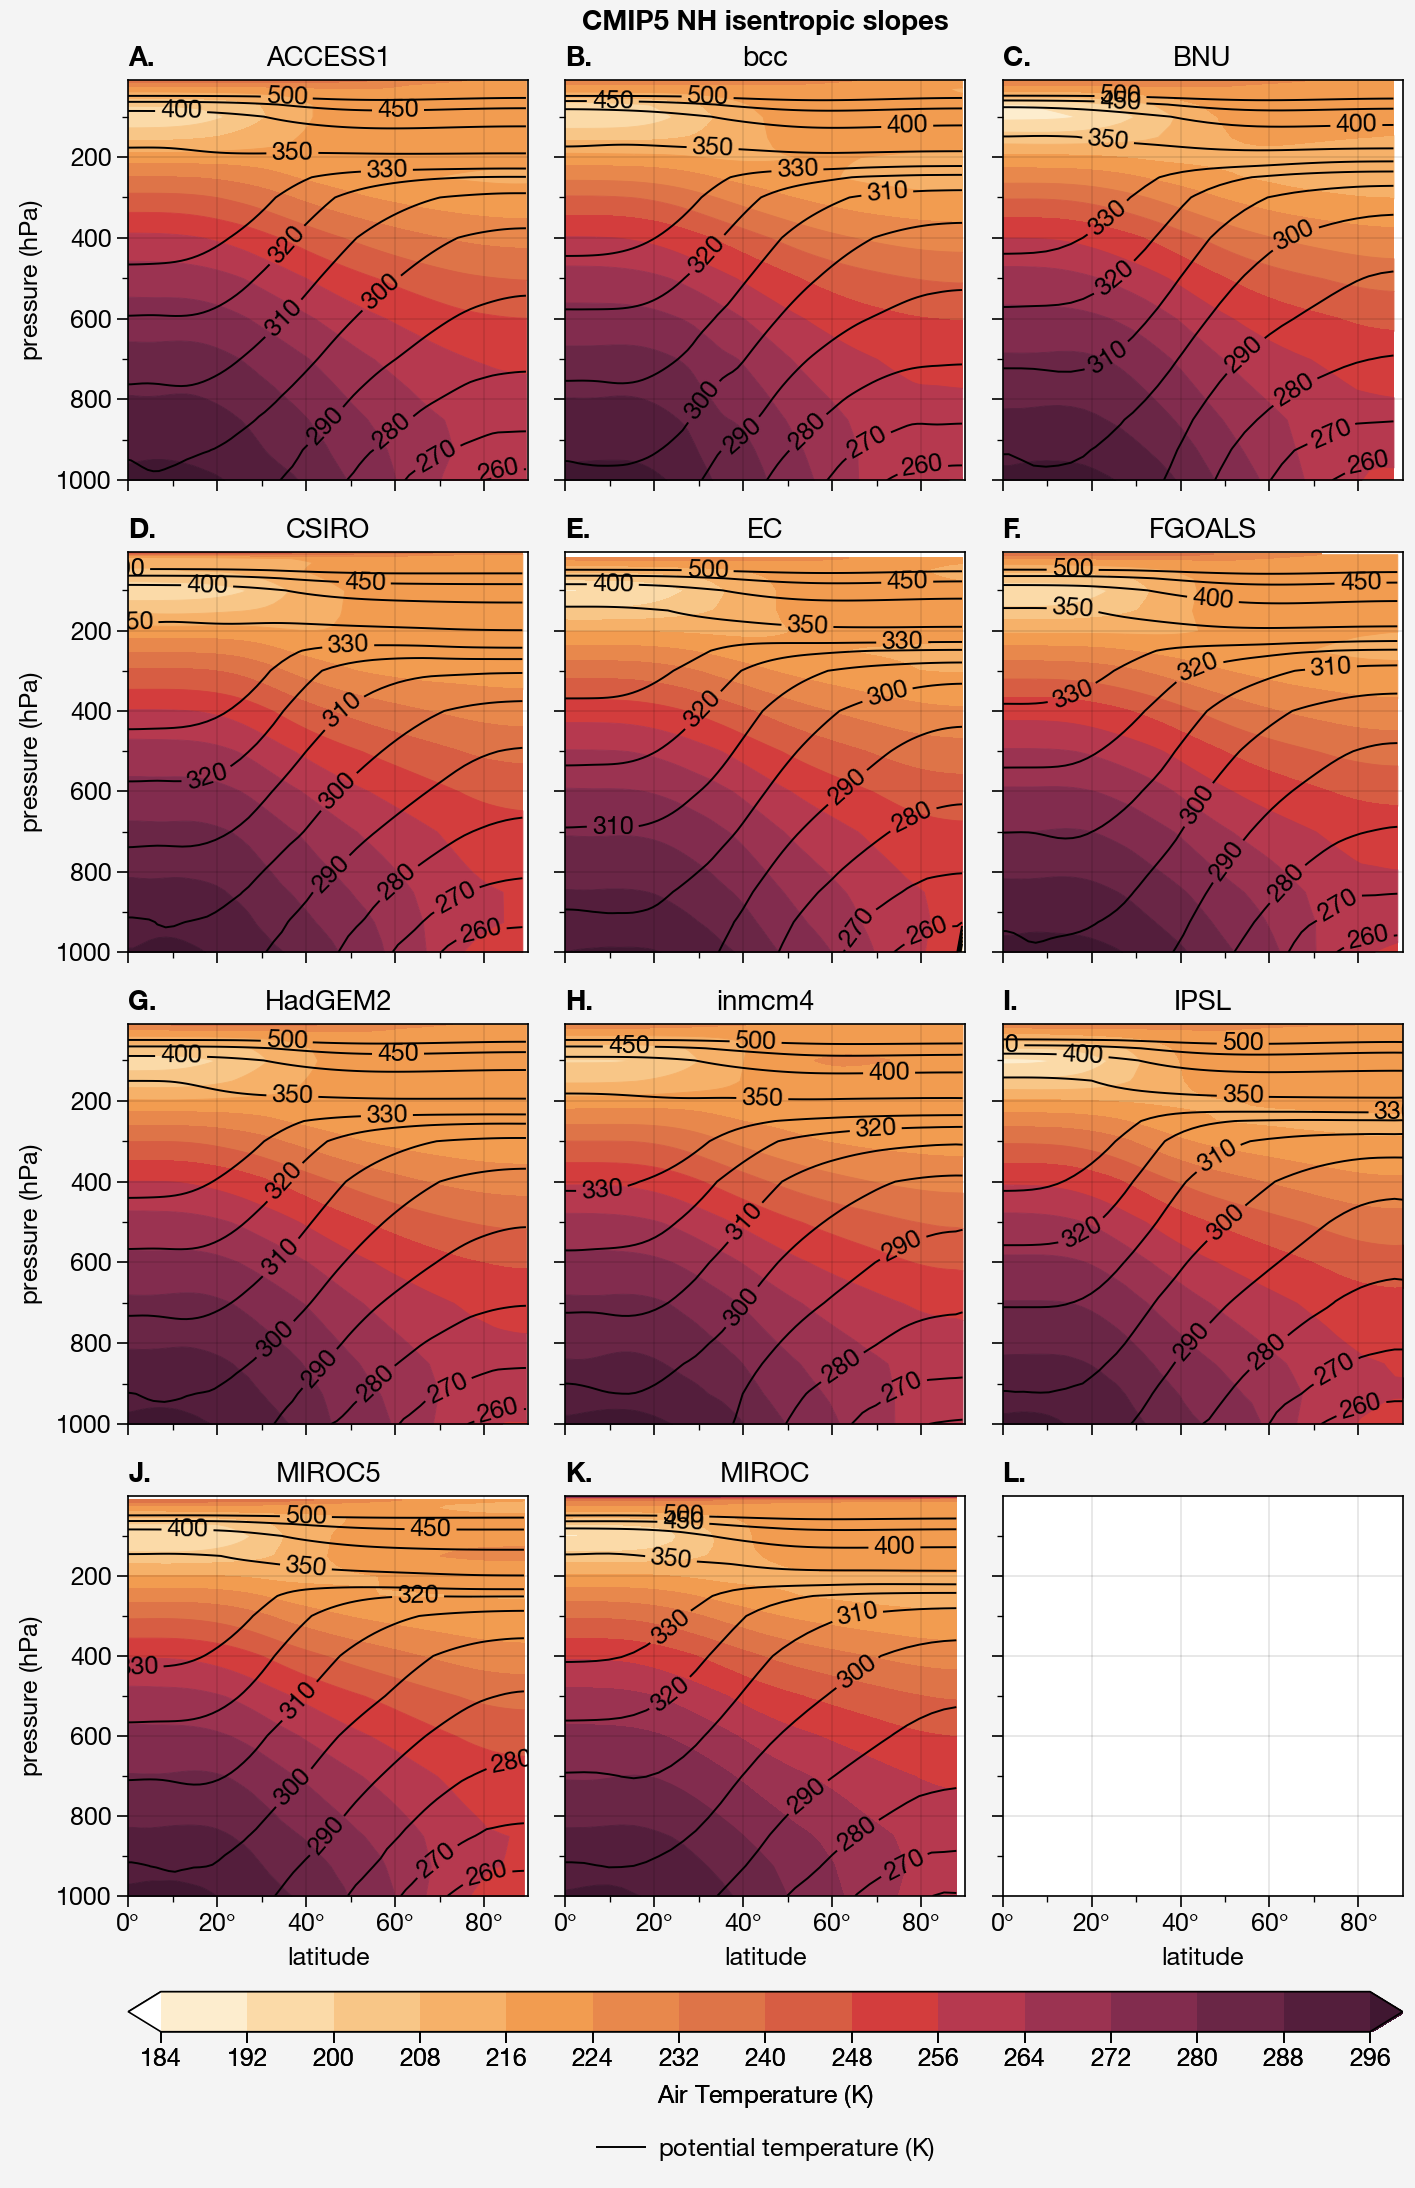

In [22]:
ptlevels = [*pplt.arange(200, 330, 10), 350, 400, 450, 500]
for hemi in ('sh', 'nh'):
    sel = {key: ds.climo.sel_hemisphere(hemi) for key, ds in cmip.items()}
    fig, axs = figures.xsections(
        *sel.values(),
        # copntourf='t',
        # contour='pt',
        contourf=('t', {'season': 'mean'}),
        contour=('pt', {'season': 'mean', 'levels': ptlevels}),
        refwidth=2,
        ncols=3,
        title=f'CMIP5 {hemi.upper()} isentropic slopes',
    )